In [80]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# **Extratrees**

In [60]:
df  = pd.read_csv("../data/processed/agg_data_ml.csv")
X = df.drop(columns=['Data', 'Eólica'])  # Features
y = df['Eólica']                          # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [61]:
modelo = ExtraTreesRegressor(n_estimators=500, random_state=42)
modelo.fit(X_train, y_train)


ExtraTreesRegressor(n_estimators=500, random_state=42)

In [62]:
y_pred = modelo.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

R²: 0.8350
MAE: 27603.52
RMSE: 36000.88


R² = 0.8331 → Excelente capacidade de explicação da variabilidade dos dados.

MAE = 26.831.69 kWh → Erro médio absoluto relativamente baixo para valores de produção diários.

RMSE = 35.308 kWh → Penaliza mais os erros maiores, ainda assim bastante razoável.

In [63]:
# Carregar o ficheiro com os dados reais
dados_reais = pd.read_csv("../data/processed/agg_data_ml.csv")
df_previsoes = pd.read_csv("../tests/previsoes_eolica_extratrees.csv")

# Converter a coluna 'Data' para datetime para cruzamento
df_previsoes['Data'] = pd.to_datetime(df_previsoes['Data'])
dados_reais['Data'] = pd.to_datetime(dados_reais['Data'])

# Juntar previsões com valores reais
df_analise = pd.merge(df_previsoes, dados_reais[['Data', 'Eólica']], on='Data', how='inner')
df_analise.rename(columns={'Eólica': 'Eolica_Real'}, inplace=True)

# Verificar estrutura
df_analise.head(25)

,Data,Eolica_Prevista,Eolica_Real
0,2013-01-04,149543.700,149543.7
1,2013-01-05,23830.800,23830.8
2,2013-01-06,19526.800,19526.8
3,2013-01-07,9623.000,9623.0
4,2013-01-08,94561.981,39302.3
5,2013-01-09,120576.800,120576.8
6,2013-01-10,84039.006,65510.1
7,2013-01-11,58813.800,58813.8
8,2013-01-12,215235.900,215235.9
9,2013-01-13,226815.700,226815.7


In [64]:
error = abs(df_analise['Eolica_Real'] - df_analise['Eolica_Prevista']) / df_analise['Eolica_Real'] * 100
print(f"Erro médio percentual: {error.mean():.2f}%")

Erro médio percentual: 6.02%


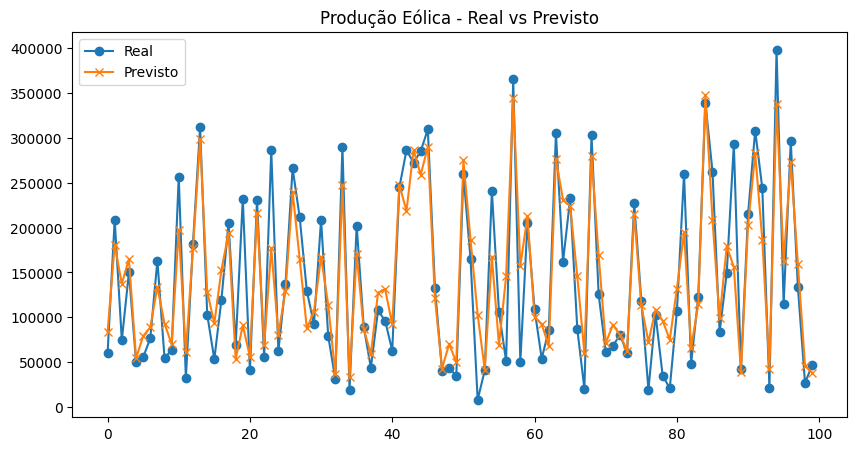

In [65]:
plt.figure(figsize=(10,5))
plt.plot(y_test.values[:100], label='Real', marker='o')
plt.plot(y_pred[:100], label='Previsto', marker='x')
plt.legend()
plt.title('Produção Eólica - Real vs Previsto')
plt.show()

# **ANN**

In [ ]:
# 1. Carregar dados
df = pd.read_csv("../data/processed/agg_data_ml.csv")

# 2. Preparar dados
X = df.drop(columns=["Data", "Eólica"])
y = df["Eólica"]

# 3. Normalização
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# 4. Separar treino, validação e teste
X_train_val, X_test, y_train_val, y_test = train_test_split(X_scaled, y_scaled, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42)

# # 5. Definir o modelo ANN
# model = Sequential([
#     Dense(50, activation='sigmoid', input_shape=(X_train.shape[1],)),
#     Dense(1, activation='linear')
# ])

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# # 6. Early stopping
# early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
early_stop = EarlyStopping(
    monitor='val_mae',#'val_loss',
    patience=50,
    restore_best_weights=True
)

# 2. Guardar o melhor modelo durante o treino
checkpoint = ModelCheckpoint(
    '../models/best_ANN.h5',
    monitor='val_mae',  # ou 'val_mae'
    save_best_only=True,
    mode='min',
    verbose=1
)

# 7. Treinar modelo
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=16,#32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/200


c:\Users\Tiago\Documents\GitHub\wind-energy-forecast\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0445 - mae: 0.1639 - val_loss: 0.0165 - val_mae: 0.0950
Epoch 2/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0211 - mae: 0.1127 - val_loss: 0.0121 - val_mae: 0.0855
Epoch 3/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0176 - mae: 0.1041 - val_loss: 0.0125 - val_mae: 0.0845
Epoch 4/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0144 - mae: 0.0927 - val_loss: 0.0133 - val_mae: 0.0891
Epoch 5/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0130 - mae: 0.0871 - val_loss: 0.0119 - val_mae: 0.0827
Epoch 6/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0115 - mae: 0.0835 - val_loss: 0.0101 - val_mae: 0.0773
Epoch 7/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0117 - mae: 0.0833 - val_loss: 0.0121 - val_mae: 0.0856
Epoch 8/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0109 - mae: 0.0800 - val_loss: 0.0114 - val_mae: 0.0824
Epoch 9/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0101 - mae: 0.0

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0077 - mae: 0.0656 
Test MSE: 0.0073
Test MAE: 0.0650
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


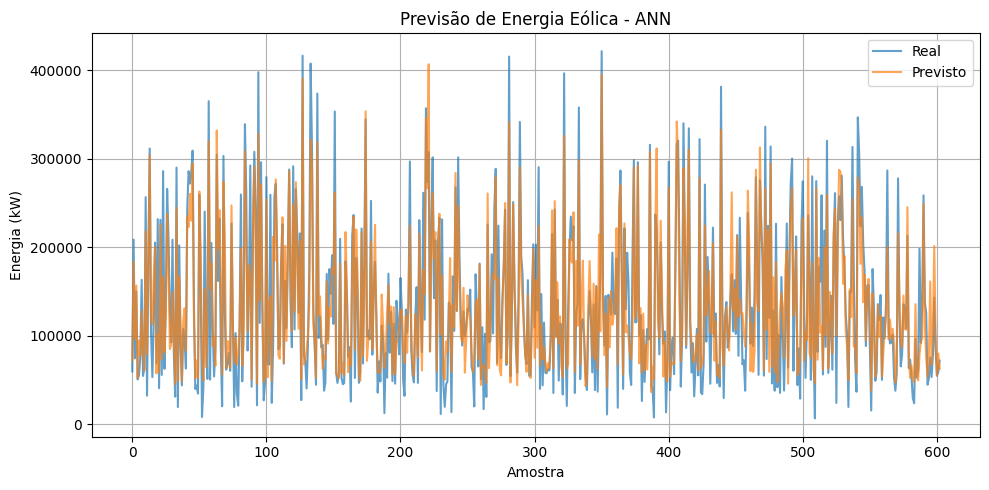

In [96]:
# 8. Avaliação no conjunto de teste
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test MSE: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# 9. Fazer previsões e inverter normalização
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_real = scaler_y.inverse_transform(y_test)

# 10. Visualizar resultado
plt.figure(figsize=(10, 5))
plt.plot(y_real, label="Real", alpha=0.7)
plt.plot(y_pred, label="Previsto", alpha=0.7)
plt.legend()
plt.title("Previsão de Energia Eólica - ANN")
plt.xlabel("Amostra")
plt.ylabel("Energia (kW)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [97]:
# Calcular SMAPE e NMAE
smape = np.mean(2.0 * np.abs(y_pred - y_real) / (np.abs(y_pred) + np.abs(y_real))) * 100
nmae = np.mean(np.abs(y_pred - y_real)) / np.mean(y_real) * 100

print(f"SMAPE: {smape:.2f}%")
print(f"NMAE: {nmae:.2f}%")

SMAPE: 26.39%
NMAE: 20.33%


In [89]:
# Para converter MAE de volta para escala real:
real_mae = scaler_y.inverse_transform([[test_mae]])[0][0]
print(f"MAE real aproximado: {real_mae:.2f} kW")


MAE real aproximado: 31805.77 kW


In [99]:
error = abs(y_real - y_pred) / y_real * 100
print(f"Erro médio percentual: {error.mean():.2f}%")

Erro médio percentual: 36.61%


In [71]:
# Definir X (com Data incluída) e y
X_full = df[['Data', 'Intensidade_Media', 'Direcao_Media', 'Temperatura_Media',
             'mes', 'dia_da_semana', 'vento_sin', 'vento_cos',
             'Intensidade_Media_lag1', 'Temperatura_Media_lag1', 'Eólica_lag1']]
y = df['Eólica']

# Fazer split em treino/teste com X_full (incluindo Data)
X_train_full, X_test_full, y_train, y_test = train_test_split(X_full, y, test_size=0.3, random_state=42)

# Separar colunas numéricas (sem 'Data') para normalização
features = ['Intensidade_Media', 'Direcao_Media', 'Temperatura_Media',
            'mes', 'dia_da_semana', 'vento_sin', 'vento_cos',
            'Intensidade_Media_lag1', 'Temperatura_Media_lag1', 'Eólica_lag1']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full[features])
X_test_scaled = scaler.transform(X_test_full[features])

# Construir e treinar o modelo ANN
ann_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])
ann_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = ann_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100


c:\Users\Tiago\Documents\GitHub\wind-energy-forecast\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 24483508224.0000 - mae: 131528.0781 - val_loss: 25776257024.0000 - val_mae: 134948.3438
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25341243392.0000 - mae: 134778.2031 - val_loss: 25766119424.0000 - val_mae: 134916.0312
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24974874624.0000 - mae: 133167.7344 - val_loss: 25733963776.0000 - val_mae: 134818.8750
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25061214208.0000 - mae: 134229.1719 - val_loss: 25663746048.0000 - val_mae: 134614.7656
Epoch 5/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25618190336.0000 - mae: 135442.4062 - val_loss: 25540595712.0000 - val_mae: 134265.3750
Epoch 6/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25445445632.0000 - mae: 134541.1719 - val_loss: 25350393856.0000 - val_mae: 133734.0000
Epoch 7/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25559638016.0000 - mae: 134798.7188 - val_loss: 25084647424.0000 - val_

In [72]:
# Previsões
predictions = ann_model.predict(X_test_scaled)

# Construir DataFrame com resultados
results = pd.DataFrame({
    'Data': X_test_full['Data'].values,
    'Real': y_test.values,
    'Previsao': predictions.flatten()
})

# Ordenar por data e guardar
results['Data'] = pd.to_datetime(results['Data'])
results = results.sort_values('Data')
results.to_csv("previsoes_ann_paper.csv", index=False)

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [73]:
media_eolica = df['Eólica'].mean()
desvio_padrao_eolica = df['Eólica'].std()

print(f"Média: {media_eolica:.2f}")
print(f"Desvio Padrão: {desvio_padrao_eolica:.2f}")

Média: 135099.02
Desvio Padrão: 86998.61


In [74]:
error = abs(results['Real'] - results['Previsao']) / results['Real'] * 100
print(f"Erro médio percentual: {error.mean():.2f}%")

Erro médio percentual: 42.85%
